In [1]:
from diffusers import BitsAndBytesConfig, SD3Transformer2DModel
from diffusers import StableDiffusion3Pipeline
import torch
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [2]:
def load_in_4bits(model_id):

    nf4_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model_nf4 = SD3Transformer2DModel.from_pretrained(
        model_id,
        subfolder="transformer",
        quantization_config=nf4_config,
        torch_dtype=torch.bfloat16
    )

    return model_nf4


## Image Generation

In [ ]:
model_id = "stabilityai/stable-diffusion-3.5-large"

model_quant = load_in_4bits(model_id)

In [ ]:

pipeline = StableDiffusion3Pipeline.from_pretrained(
    model_id, 
    transformer=model_quant,
    torch_dtype=torch.bfloat16
)

pipeline.enable_model_cpu_offload()

In [ ]:
prompt = "A whimsical and creative image depicting a hybrid creature that is a mix of a waffle and a hippopotamus, basking in a river of melted butter amidst a breakfast-themed landscape. It features the distinctive, bulky body shape of a hippo. However, instead of the usual grey skin, the creature's body resembles a golden-brown, crispy waffle fresh off the griddle. The skin is textured with the familiar grid pattern of a waffle, each square filled with a glistening sheen of syrup. The environment combines the natural habitat of a hippo with elements of a breakfast table setting, a river of warm, melted butter, with oversized utensils or plates peeking out from the lush, pancake-like foliage in the background, a towering pepper mill standing in for a tree.  As the sun rises in this fantastical world, it casts a warm, buttery glow over the scene. The creature, content in its butter river, lets out a yawn. Nearby, a flock of birds take flight"

image = pipeline(
    prompt=prompt,
    num_inference_steps=28,
    guidance_scale=4.5,
    max_sequence_length=512,
).images[0]
image.save("whimsical.png")

## Inpainting

In [2]:
from diffusers import StableDiffusionXLInpaintPipeline

In [3]:
base_model_id = "stabilityai/stable-diffusion-XL-base-1.0"
refiner_model_id = "stabilityai/stable-diffusion-XL-refiner-1.0"

In [ ]:
base_inpainting = StableDiffusionXLInpaintPipeline.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
).to("cuda")

base_inpainting.enable_model_cpu_offload()

# base_inpainting.unet = torch.compile(base_inpainting.unet, mode="reduce-overhead", fullgraph=True)

In [ ]:
refiner_pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    refiner_model_id,
    text_encoder=base_inpainting.text_encoder_2,
    vae=base_inpainting.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
).to("cuda")

#refiner_pipe.unet = torch.compile(refiner_pipe.unet, mode="reduce-overhead", fullgraph=True)

refiner_pipe.enable_model_cpu_offload()

In [6]:
def inpaint(init_image, mask_image, prompt, negative_prompt= None, use_refiner=True, seed=None, n_steps= 50, **kwargs):
    """
    Performs inpainting of an image using the StableDiffusionXLInpaintPipeline.

    Args:
        init_image (torch.Tensor): The initial image to start the inpainting process.
        mask_image (torch.Tensor): The mask image indicating the area to inpaint.
        prompt (str): The text prompt to guide the inpainting process.
        negative_prompt (str, optional): The text prompt to avoid when inpainting. Defaults to None.
        use_refiner (bool, optional): Determines whether to use the refiner or not. Defaults to True.
        seed (int, optional): The random seed used for generating the image. Defaults to None.
        n_steps (int, optional): The number of steps to take when inpainting the image. Defaults to 50.
        **kwargs: Additional keyword arguments for the StableDiffusionXLInpaintPipeline.

    Returns:
        PIL.Image: The inpainted image.

    Note:
        This function uses the StableDiffusionXLInpaintPipeline to inpaint an image based on the given text prompt. 
        It can optionally use a refiner for better image quality and can be set to avoid certain themes by 
        using a negative prompt. A random seed can be specified for reproducibility.
    """

    high_noise_frac = 0.7

    if seed:
        generator = torch.Generator(device="cuda").manual_seed(seed)
    else:
        generator = None
    
    image = base_inpainting(prompt= prompt,
                negative_prompt= negative_prompt,
                image=init_image,
                mask_image=mask_image, 
                num_inference_steps= n_steps,
                strength=0.8,
                denoising_end= high_noise_frac if use_refiner else 1.0,
                output_type= "latent" if use_refiner else "pil",
                generator= generator,
                **kwargs).images[0]

    if use_refiner:
        image = refiner_pipe(prompt=prompt,
                        negative_prompt= negative_prompt,
                        mask_image=mask_image,  
                        num_inference_steps= n_steps,
                        denoising_start = high_noise_frac,
                        image=image[None, :], 
                        generator= generator).images[0]

    return image

def show_images_side_by_side(images, titles=None, rows=1):
    num_images = len(images)
    cols = num_images // rows + (num_images % rows > 0)
    plt.figure(figsize=(20,10)) # You can adjust the figure size as per your requirement

    for i, image in enumerate(images):
        plt.subplot(rows,cols,i+1) # "rows,cols,i+1" means: in a grid rows x cols, put this in the i+1 slot
        plt.imshow(image)
        if titles is not None:
            plt.title(titles[i])
        plt.axis('off')   # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

In [7]:
img_path = "no-smile-1024.png"
mask = "no-smile-big-mask.png"

init_image = Image.open(img_path).convert('RGB')
mask_image = Image.open(mask).convert('RGB')

In [ ]:
prompt="women formal attire in blue, perl necklace, detailed, photorealistic, professional photo shooting, fashion magazine."
negative_prompt = "deformed. disfigured, underexposed, overexposed"

refined = inpaint(init_image, mask_image, prompt, negative_prompt, use_refiner=True, seed=42, n_steps=80)

show_images_side_by_side(
    images=[init_image, refined],
    titles=["Original", "Inpainting + Refinement"]
)

In [ ]:
base_inpainting?

## Endpoint

In [1]:
import io, requests
from PIL import Image

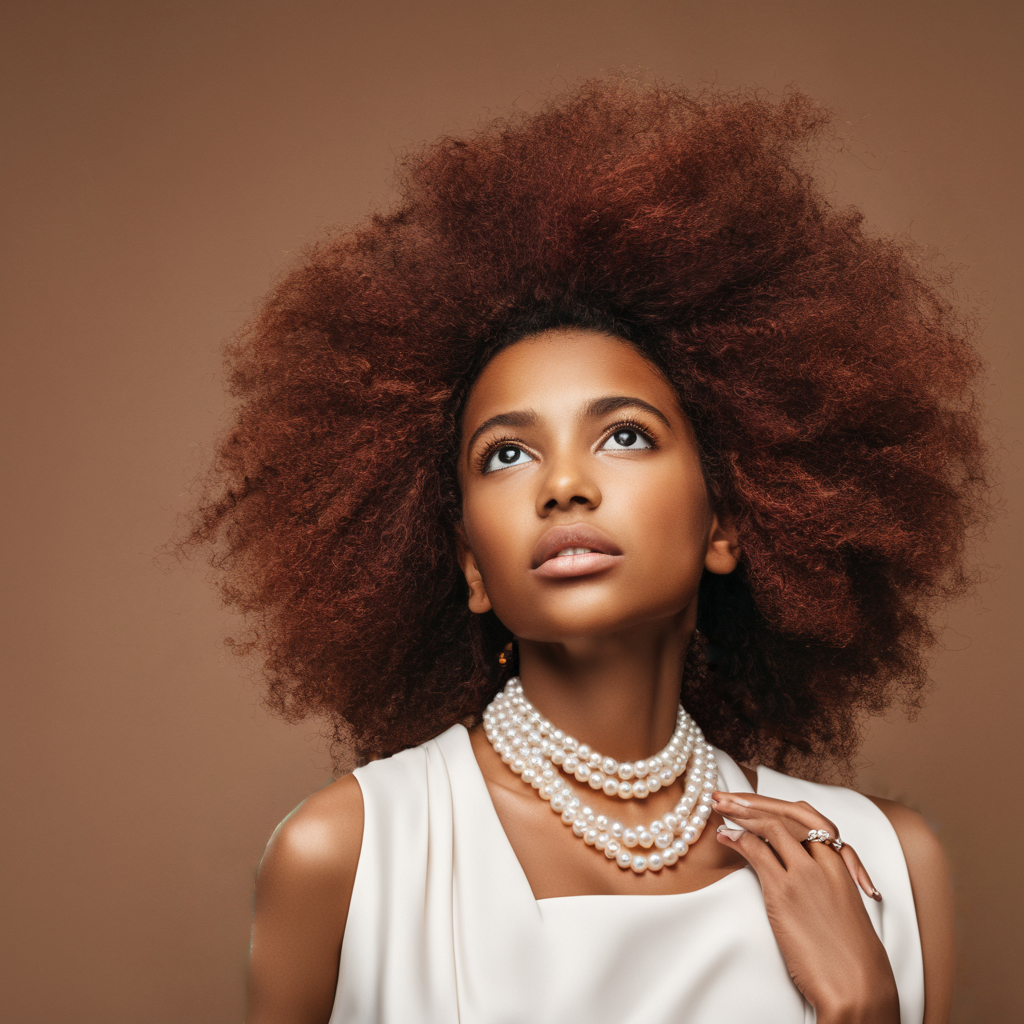

Inpainting successful. Image displayed and saved as 'output_image_pil.png'.


In [2]:
# Endpoint URL
url = "http://127.0.0.1:8000/inpaint"

# Files to upload
files = {
    'init_image': open('no-smile-1024.png', 'rb'),  # Replace with your initial image path
    'mask_image': open('no-smile-big-mask.png', 'rb')   # Replace with your mask image path
}

# Form data
data = {
    'prompt': 'red fancy attire, white pearl necklace, detailed, photorealistic, professional photo shooting, fashion magazine.',
    'negative_prompt': 'hands, deformed, disfigured, underexposed, overexposed',
    'use_refiner': 'true',
    #'seed': '2',
    'n_steps': '100',
    'high_noise_frac': '0.7'
}

# Sending POST request
response = requests.post(url, files=files, data=data)

# Save the response image
if response.status_code == 200:
     # Transform the response content into a PIL image
    image = Image.open(io.BytesIO(response.content))
    image.show()  # Display the image
    # Optionally, save the image
    image.save('output_image_pil.png')
    print("Inpainting successful. Image displayed and saved as 'output_image_pil.png'.")
else:
    print(f"Error: {response.status_code}")
    print(response.text)